In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
import shap
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("finalfile.txt", sep="\t")

In [3]:
df.dtypes

strain             object
A1C                 int64
A1G                 int64
A1T                 int64
T2G                 int64
                    ...  
Nextclade_pango    object
region             object
country            object
category           object
Collection date    object
Length: 16424, dtype: object

In [4]:
finalfile=df

In [5]:
finalfile["Collection date"] = pd.to_datetime(
    finalfile["Collection date"], 
    format="mixed", 
    dayfirst=True)

In [6]:
print(finalfile["Collection date"].dtypes)
print(finalfile["Collection date"].head())

datetime64[ns]
0   2024-01-12
1   2024-01-03
2   2024-01-06
3   2024-01-30
4   2024-01-01
Name: Collection date, dtype: datetime64[ns]


In [7]:
final_df=finalfile

In [8]:
final_df

strain  A1C  A1G  A1T  T2G  T2K  \
0       hCoV-19/Turkey/TSIM_Ankara_140111_978/2024    0    0    0    0    0   
1      hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024    0    0    0    1    0   
2                hCoV-19/Brazil/RJ-FIOCRUZ-51/2024    0    0    0    1    0   
3               hCoV-19/Fujian/FCDC-FZ9970725/2024    0    0    0    1    0   
4              hCoV-19/Fujian/FCDC-XM010309HG/2024    0    0    0    1    0   
...                                            ...  ...  ...  ...  ...  ...   
13968     hCoV-19/Spain/CT-LabRefCat-9317885r/2024    0    0    0    1    0   
13969     hCoV-19/Spain/CT-LabRefCat-6385185r/2024    0    0    0    1    0   
13970                 hCoV-19/USA/NY-WMC-6178/2024    0    0    0    1    0   
13971        hCoV-19/Mexico/GUA_CIAD_01001002/2024    0    0    0    1    0   
13972          hCoV-19/Brazil/SC-FIOCRUZ-1104/2024    0    0    0    1    0   

       T2A  T2C  T3C  T3A  ...  A29891G  A29892G  Gender  Patient age  \
0        0    0    0    0  ...        0        0    Male        87.00   
1        0    0    1    0  ...        1        1  Female        91.00   
2        0    0    1    0  ...        1        1    Male        35.00   
3        0    0    1    0  ...        1        1    Male        70.00   
4        0    0    1    0  ...        1        1  Female        19.00   
...    ...  ...  ...  ...  ...      ...      ...     ...          ...   
13968    0    0    1    0  ...        1        1    Male        94.00   
13969    0    0    1    0  ...        1        1  Female        81.00   
13970    0    0    1    0  ...        1        1    Male         0.42   
13971    0    0    1    0  ...        1        1  Female        26.00   
13972    0    0    1    0  ...        1        1    Male        38.00   

             clade  Nextclade_pango         region   country  category  \
0              19A                B         Europe    Turkey    Severe   
1      recombinant              XCU         Europe  Slovakia    Severe   
2              21K             BA.1  South America    Brazil    Severe   
3              23F         EG.5.1.1           Asia     China    Severe   
4              23H             HK.3           Asia     China    Severe   
...            ...              ...            ...       ...       ...   
13968          24A         JN.1.4.9         Europe     Spain    Severe   
13969          24E         KP.3.1.1         Europe     Spain    Severe   
13970          24A           JN.1.4  North America       USA    Severe   
13971          23B      XBB.1.16.15  North America    Mexico    Severe   
13972          23G             GK.1  South America    Brazil    Severe   

       Collection date  
0           2024-01-12  
1           2024-01-03  
2           2024-01-06  
3           2024-01-30  
4           2024-01-01  
...                ...  
13968       2024-05-03  
13969       2024-10-11  
13970       2024-03-01  
13971       2024-02-08  
13972       2024-02-04  

[13973 rows x 16424 columns]

In [9]:
final_df['category'] = pd.get_dummies(final_df['category'])['Severe'].astype(int)
print(final_df['category'].head())

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int64


In [10]:
final_df['Gender'] = pd.get_dummies(final_df['Gender'])['Female'].astype(int)
print(final_df['Gender'].head())

0    0
1    1
2    0
3    0
4    1
Name: Gender, dtype: int64


In [11]:
clade_dummies = pd.get_dummies(final_df ['clade'], prefix='clade').astype(int)
final_df  = pd.concat([final_df , clade_dummies], axis=1)
final_df  = final_df .drop(['clade', 'clade_24C'], axis = 1)

In [12]:
Nextclade_dummies = pd.get_dummies(final_df ['Nextclade_pango'], prefix='Nextclade_pango').astype(int)
final_df  = pd.concat([final_df , Nextclade_dummies], axis=1)
final_df = final_df.drop(['Nextclade_pango', 'Nextclade_pango_XEN'], axis = 1)

In [13]:
region_dummies = pd.get_dummies(final_df['region'], prefix='region').astype(int)
final_df = pd.concat([final_df, region_dummies], axis=1)
final_df = final_df.drop(['region', 'region_Africa'], axis = 1)

In [14]:
country_dummies = pd.get_dummies(final_df['country'], prefix='country').astype(int)
final_df = pd.concat([final_df , country_dummies], axis=1)
final_df = final_df.drop(['country', 'country_Senegal'], axis = 1)

In [15]:
final_df

strain  A1C  A1G  A1T  T2G  T2K  \
0       hCoV-19/Turkey/TSIM_Ankara_140111_978/2024    0    0    0    0    0   
1      hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024    0    0    0    1    0   
2                hCoV-19/Brazil/RJ-FIOCRUZ-51/2024    0    0    0    1    0   
3               hCoV-19/Fujian/FCDC-FZ9970725/2024    0    0    0    1    0   
4              hCoV-19/Fujian/FCDC-XM010309HG/2024    0    0    0    1    0   
...                                            ...  ...  ...  ...  ...  ...   
13968     hCoV-19/Spain/CT-LabRefCat-9317885r/2024    0    0    0    1    0   
13969     hCoV-19/Spain/CT-LabRefCat-6385185r/2024    0    0    0    1    0   
13970                 hCoV-19/USA/NY-WMC-6178/2024    0    0    0    1    0   
13971        hCoV-19/Mexico/GUA_CIAD_01001002/2024    0    0    0    1    0   
13972          hCoV-19/Brazil/SC-FIOCRUZ-1104/2024    0    0    0    1    0   

       T2A  T2C  T3C  T3A  ...  country_Russia  country_Saint Martin  \
0        0    0    0    0  ...               0                     0   
1        0    0    1    0  ...               0                     0   
2        0    0    1    0  ...               0                     0   
3        0    0    1    0  ...               0                     0   
4        0    0    1    0  ...               0                     0   
...    ...  ...  ...  ...  ...             ...                   ...   
13968    0    0    1    0  ...               0                     0   
13969    0    0    1    0  ...               0                     0   
13970    0    0    1    0  ...               0                     0   
13971    0    0    1    0  ...               0                     0   
13972    0    0    1    0  ...               0                     0   

       country_Slovakia  country_Spain  country_Taiwan  country_Thailand  \
0                     0              0               0                 0   
1                     1              0               0                 0   
2                     0              0               0                 0   
3                     0              0               0                 0   
4                     0              0               0                 0   
...                 ...            ...             ...               ...   
13968                 0              1               0                 0   
13969                 0              1               0                 0   
13970                 0              0               0                 0   
13971                 0              0               0                 0   
13972                 0              0               0                 0   

       country_Turkey  country_USA  country_Uganda  country_Vietnam  
0                   1            0               0                0  
1                   0            0               0                0  
2                   0            0               0                0  
3                   0            0               0                0  
4                   0            0               0                0  
...               ...          ...             ...              ...  
13968               0            0               0                0  
13969               0            0               0                0  
13970               0            1               0                0  
13971               0            0               0                0  
13972               0            0               0                0  

[13973 rows x 17114 columns]

In [16]:
first_col = final_df.loc[:, ["strain", "Collection date"]]

In [17]:
rest = final_df.drop(columns=["strain", "Collection date"])
rest

A1C  A1G  A1T  T2G  T2K  T2A  T2C  T3C  T3A  A4T  ...  country_Russia  \
0        0    0    0    0    0    0    0    0    0    0  ...               0   
1        0    0    0    1    0    0    0    1    0    1  ...               0   
2        0    0    0    1    0    0    0    1    0    1  ...               0   
3        0    0    0    1    0    0    0    1    0    1  ...               0   
4        0    0    0    1    0    0    0    1    0    1  ...               0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...             ...   
13968    0    0    0    1    0    0    0    1    0    1  ...               0   
13969    0    0    0    1    0    0    0    1    0    1  ...               0   
13970    0    0    0    1    0    0    0    1    0    1  ...               0   
13971    0    0    0    1    0    0    0    1    0    1  ...               0   
13972    0    0    0    1    0    0    0    1    0    1  ...               0   

       country_Saint Martin  country_Slovakia  country_Spain  country_Taiwan  \
0                         0                 0              0               0   
1                         0                 1              0               0   
2                         0                 0              0               0   
3                         0                 0              0               0   
4                         0                 0              0               0   
...                     ...               ...            ...             ...   
13968                     0                 0              1               0   
13969                     0                 0              1               0   
13970                     0                 0              0               0   
13971                     0                 0              0               0   
13972                     0                 0              0               0   

       country_Thailand  country_Turkey  country_USA  country_Uganda  \
0                     0               1            0               0   
1                     0               0            0               0   
2                     0               0            0               0   
3                     0               0            0               0   
4                     0               0            0               0   
...                 ...             ...          ...             ...   
13968                 0               0            0               0   
13969                 0               0            0               0   
13970                 0               0            1               0   
13971                 0               0            0               0   
13972                 0               0            0               0   

       country_Vietnam  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
13968                0  
13969                0  
13970                0  
13971                0  
13972                0  

[13973 rows x 17112 columns]

In [18]:
filtered_rest = rest.loc[:, (rest.sum(axis=0) >= 10)]
final_df_filtered = pd.concat([first_col, filtered_rest], axis=1)
print("Filtered shape:", final_df_filtered.shape)

Filtered shape: (13973, 9635)


In [19]:
final_df_filtered

strain Collection date  T2G  T3C  \
0       hCoV-19/Turkey/TSIM_Ankara_140111_978/2024      2024-01-12    0    0   
1      hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024      2024-01-03    1    1   
2                hCoV-19/Brazil/RJ-FIOCRUZ-51/2024      2024-01-06    1    1   
3               hCoV-19/Fujian/FCDC-FZ9970725/2024      2024-01-30    1    1   
4              hCoV-19/Fujian/FCDC-XM010309HG/2024      2024-01-01    1    1   
...                                            ...             ...  ...  ...   
13968     hCoV-19/Spain/CT-LabRefCat-9317885r/2024      2024-05-03    1    1   
13969     hCoV-19/Spain/CT-LabRefCat-6385185r/2024      2024-10-11    1    1   
13970                 hCoV-19/USA/NY-WMC-6178/2024      2024-03-01    1    1   
13971        hCoV-19/Mexico/GUA_CIAD_01001002/2024      2024-02-08    1    1   
13972          hCoV-19/Brazil/SC-FIOCRUZ-1104/2024      2024-02-04    1    1   

       A4T  A4C  A5G  A6R  G7T  G8T  ...  country_Pakistan  country_Paraguay  \
0        0    0    0    0    0    0  ...                 0                 0   
1        1    0    1    1    1    1  ...                 0                 0   
2        1    0    1    1    1    1  ...                 0                 0   
3        1    0    1    1    1    1  ...                 0                 0   
4        1    0    1    1    1    1  ...                 0                 0   
...    ...  ...  ...  ...  ...  ...  ...               ...               ...   
13968    1    0    1    1    1    1  ...                 0                 0   
13969    1    0    1    1    1    1  ...                 0                 0   
13970    1    0    1    1    1    1  ...                 0                 0   
13971    1    0    1    1    1    1  ...                 0                 0   
13972    1    0    1    1    1    1  ...                 0                 0   

       country_Poland  country_Qatar  country_Slovakia  country_Spain  \
0                   0              0                 0              0   
1                   0              0                 1              0   
2                   0              0                 0              0   
3                   0              0                 0              0   
4                   0              0                 0              0   
...               ...            ...               ...            ...   
13968               0              0                 0              1   
13969               0              0                 0              1   
13970               0              0                 0              0   
13971               0              0                 0              0   
13972               0              0                 0              0   

       country_Taiwan  country_Thailand  country_USA  country_Vietnam  
0                   0                 0            0                0  
1                   0                 0            0                0  
2                   0                 0            0                0  
3                   0                 0            0                0  
4                   0                 0            0                0  
...               ...               ...          ...              ...  
13968               0                 0            0                0  
13969               0                 0            0                0  
13970               0                 0            1                0  
13971               0                 0            0                0  
13972               0                 0            0                0  

[13973 rows x 9635 columns]

In [20]:
X = final_df_filtered.drop(columns=['category', 'strain', 'Collection date'])

In [21]:
y = final_df_filtered['category']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int64

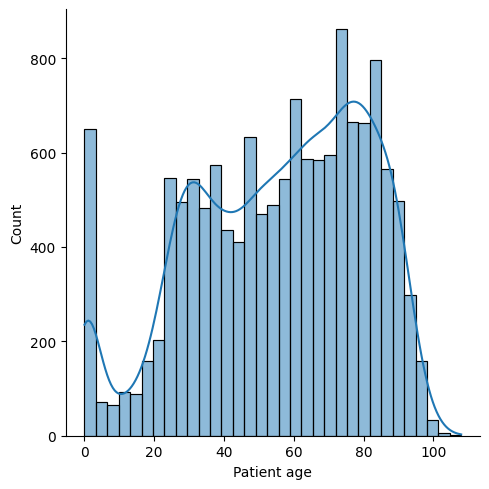

In [22]:
sns.displot(X["Patient age"], kde=True)
plt.show()

In [23]:
p = final_df_filtered["Collection date"].dt.to_period("M")
time_points = p.sort_values().unique()

In [24]:
def compute_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        m = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if np.any(m):
            acc = np.mean(y_true[m])
            conf = np.mean(y_prob[m])
            ece += (np.sum(m) / len(y_true)) * np.abs(acc - conf)
    return float(ece)

def choose_bins(n_train: int, n_test: int, min_per_bin: int = 50,
                min_bins: int = 5, max_bins: int = 20) -> int:
    n = min(int(n_train), int(n_test))
    return max(min_bins, min(max_bins, n // min_per_bin))

In [25]:
def compute_psi_quantile(expected, actual, bins: int = None, eps: float = 1e-6):
    expected = np.asarray(expected, dtype=float)
    actual   = np.asarray(actual, dtype=float)
    if bins is None:
        bins = choose_bins(len(expected), len(actual))
    if np.nanstd(expected) == 0 and np.nanstd(actual) == 0:
        return 0.0
    q = np.linspace(0, 1, bins + 1)
    edges = np.unique(np.quantile(expected, q))
    if len(edges) < 3:
        return 0.0
    exp_counts, _ = np.histogram(expected, bins=edges)
    act_counts, _ = np.histogram(actual,   bins=edges)
    exp_prop = exp_counts / max(1, exp_counts.sum())
    act_prop = act_counts / max(1, act_counts.sum())
    exp_prop = np.where(exp_prop == 0, eps, exp_prop)
    act_prop = np.where(act_prop == 0, eps, act_prop)
    return float(np.sum((exp_prop - act_prop) * np.log(exp_prop / act_prop)))

In [26]:
def shap_values_2d(model, X_train):
    explainer = shap.TreeExplainer(model, feature_perturbation="interventional")
    sv = explainer.shap_values(X_train, check_additivity=False)
    if isinstance(sv, list) and len(sv) == 2:
        sv = sv[1]
    return np.asarray(sv)


In [27]:
n_months = final_df_filtered["Collection date"].dt.to_period("M").nunique()
print("Number of unique months:", n_months)

Number of unique months: 17


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, roc_auc_score, brier_score_loss

results = []

p = final_df_filtered["Collection date"].dt.to_period("M")
time_points = pd.period_range(p.min(), p.max(), freq="M")
# choose how soon to start (e.g., after first 3 months)
start_after = 3  # try 3 or 6
for i in range(start_after, len(time_points)-1):
    train_end = time_points[i]
    test_end  = time_points[i+1]

    train_idx = p <= train_end
    test_idx  = (p > train_end) & (p <= test_end)

    if test_idx.sum()<20 or train_idx.sum() < 80:

        continue

    print(f"Split {i}: train_end={train_end}, test_end={test_end}, "
          f"n_train={train_idx.sum()}, n_test={test_idx.sum()}")
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    X_train.isnull().sum()
    X_train["Patient age"].min(), X_train["Patient age"].max(), X_train["Patient age"].mean(), X_train["Patient age"].std()
    X_test["Patient age"].min(), X_test["Patient age"].max(), X_test["Patient age"].mean(), X_test["Patient age"].std()
    scaler = StandardScaler()
    X_train[["Patient age"]] = scaler.fit_transform(X_train[["Patient age"]])
    X_test[["Patient age"]] = scaler.transform(X_test[["Patient age"]])
    X_train["Patient age"].min(), X_train["Patient age"].max(), X_train["Patient age"].mean(), X_train["Patient age"].std()
    X_test["Patient age"].min(), X_test["Patient age"].max(), X_test["Patient age"].mean(), X_test["Patient age"].std()
    print (X_train.shape)
    print (X_test.shape)
    print (y_train.shape)
    print (y_test.shape)
    param_dist = {'n_estimators': randint(500, 2100),'max_depth': randint(10, 41),'learning_rate': uniform(0.001, 0.099),'reg_lambda': uniform(0.0, 3.0),'gamma': uniform(0.0, 2.0)}
    cv = KFold(n_splits=5, shuffle=False)
    scorer = make_scorer(accuracy_score)
    model = XGBClassifier()
    random_search = RandomizedSearchCV(estimator=model,param_distributions=param_dist,n_iter=50,scoring=scorer,cv=cv,verbose=2,n_jobs=2,random_state=42)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    print("\n Best Parameters Found:", random_search.best_params_)
    print("\n Test Set Performance:")
    print(confusion_matrix(y_test, y_pred))
    print("Test ROC AUC:", roc_auc_score(y_test, y_prob))
    auc   = roc_auc_score(y_test, y_prob)
    ece   = compute_ece(y_test.values, y_prob, n_bins=10)
    brier = brier_score_loss(y_test, y_prob)  # Brier uses probabilities

    sv = shap_values_2d(best_model, X_train)
    mean_abs_shap = np.mean(np.abs(sv), axis=0)
    top_idx = np.argsort(mean_abs_shap)[-10:]
    top_feats = [X_train.columns[j] for j in top_idx]

    psi_feat = {}
    for f in top_feats:
        psi_feat[f] = compute_psi_quantile(X_train[f].values, X_test[f].values)
    avg_psi_top10 = float(np.mean(list(psi_feat.values())))
    max_psi_top10 = float(np.max(list(psi_feat.values())))
    # PSI on predicted scores (score-level drift)
    y_prob_train = best_model.predict_proba(X_train)[:, 1]
    psi_score = compute_psi_quantile(y_prob_train, y_prob)

    auroc_thresh = 0.70
    psi_thresh   = 0.25 
    pred_psi_thresh=1.5 
    
    if auc < auroc_thresh or max_psi_top10 > psi_thresh:
        status = "Retraining needed"
    elif psi_score > pred_psi_thresh:
        status = "Recalibration needed"
    else:
        status = "Stable"
 
    retrain_flag     = (status == "Retraining needed")
    recalibrate_flag = (status == "Recalibration needed")
    
    print(f"\n[{str(train_end)} ➜ {str(test_end)}] "
          f"AUROC={auc:.3f} | ECE={ece:.3f} | Brier={brier:.3f} | "
          f"AvgPSI_top10={avg_psi_top10:.3f} | MaxPSI_top10={max_psi_top10:.3f} | "
          f"PSI_score={psi_score:.3f} | Status={status} | "
          f"RetrainFlag={int(retrain_flag)} | RecalibrateFlag={int(recalibrate_flag)}")
    print("Top drifting features (PSI):",
          sorted(psi_feat.items(), key=lambda kv: kv[1], reverse=True)[:5])
  
    results.append({
        "train_end": str(train_end),
        "test_end":  str(test_end),
        "n_train": int(train_idx.sum()),
        "n_test":  int(test_idx.sum()),
        "AUROC": auc,
        "ECE": ece,
        "Brier": brier,
        "Avg_PSI_top10": avg_psi_top10,
        "Max_PSI_top10": max_psi_top10,
        "PSI_score": psi_score,
        "Retrain": retrain_flag,
        "Recaliberate": recalibrate_flag,
        "Top10_features": ",".join(top_feats),
        "Top3_PSI_features": ",".join([f"{k}:{psi_feat[k]:.3f}"
                                       for k,_ in sorted(psi_feat.items(), key=lambda kv: kv[1], reverse=True)[:3]])
    })

results_df = pd.DataFrame(results)
print(results_df.head())



Split 3: train_end=2024-04, test_end=2024-05, n_train=4973, n_test=1110
(4973, 9632)
(1110, 9632)
(4973,)
(1110,)
Fitting 5 folds for each of 50 candidates, totalling 250 fits
